
# Business Problem 

## Insurance All

The following context is completely fictitious. And the problem was taken from the blog: https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

Insurance All is a company that provides health insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: Auto insurance.

As with health insurance, customers of this new car insurance plan need to pay an amount annually to Insurance All to obtain an amount insured by the company, intended for the costs of an eventual accident or damage to the vehicle.

Insurance All surveyed nearly 380,000 customers about their interest in joining a new auto insurance product last year. All customers showed interest or not in purchasing vehicle insurance and these responses were saved in a database along with other attributes.

The product team selected 127,000 new customers who did not respond to the survey to participate in a campaign, in which they will be offered the new auto insurance product. The offer will be made by the sales team through phone calls.

However, the sales team has the capacity to make 20,000 calls within the campaign period.

# Challenge

build a model that predicts the probability that a customer will be classified as a person who will want to purchase new insurance.

With their solution, the sales team hopes to be able to prioritize the people with the greatest interest in the new product and thus optimize the campaign by making contacts only to the customers most likely to make the purchase.

- Deliver a report containing some analysis and answers to the following questions:

    1. Main Insights into the most relevant attributes of customers interested in purchasing auto insurance.

    2. What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?
    
    3. And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?
    
    4. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

# Solution Approach

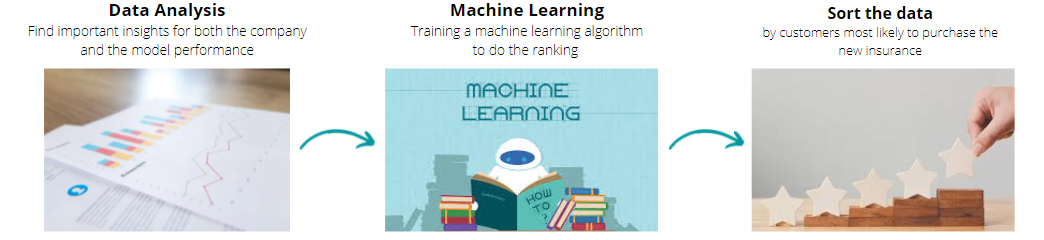


# Data info

The dataset is available on the Kaggle platform via this link: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

Each row represents a customer and each column contains some attributes that describe that customer, in addition to her survey response, in which she mentioned interest or not in the new insurance product.

The dataset includes the following information:

- Id: unique customer identifier.
- Gender: customer's gender.
- Age: customer's age.
- Driving License: 0, the client is not allowed to drive and 1, the client has to drive (CNH – National Driver's License)
- Region Code: customer's region code.
- Previously Insured: 0, the customer does not have auto insurance, and 1, the customer already has auto insurance.
- Vehicle Age: age of the vehicle.
- Vehicle Damage: 0, customer has never had his vehicle damaged in the past, and 1, customer has had his vehicle damaged in the past.
- Annual Premium: the amount the customer paid the company for annual health insurance.
- Policy sales channel: anonymous code for the customer contact channel.
- Vintage: number of days that the customer was associated with the company through the purchase of health insurance.
- Response: 0, the customer is not interested and 1, the customer is interested.

# 0.0. Imports

In [1]:
import os
import sys
import inflection
import pickle
import requests

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

#from config                  import config
from sqlalchemy              import create_engine
from tabulate                import tabulate
from scipy                   import stats

from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

# intel core to opt sklearn
from sklearnex import patch_sklearn

from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve

# my functions
path = os.path.dirname(os.getcwd())
sys.path.insert(0, path + '/utils')

from utils import cramer_v, cross_validation, numeric_statistics, precision_at_k, recall_at_k

In [2]:
pallete  = sns.color_palette(sns.diverging_palette(250, 10, s=75, l=45, n=9))
pallete2 = sns.color_palette(sns.diverging_palette(45, 200, s=75, l=45, n=9)) 

%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

sns.set_palette( pallete )
sns.set_style('darkgrid')

# set the intel sklearn extension
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 0.2. Loading Data

In [3]:
df_raw = pd.read_csv('../data/train.csv')

# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
# rename columns
old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )
new_columns = list( map( snakecase, old_columns ) )

df1.columns = new_columns

## 1.1. Data Dimension

In [6]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [8]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [9]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64'] )

Descriptive Analysis for each numeric variable. It might be important to take a look at some behavior that a variable might have initially.

1. For instance, I'm able to see the variable 'age' has 66 different values which start from 20 years to 85, and it has its mean and median value close.

2. As seen the target variable has a binary result ( '0' or '1' )

In [10]:
numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
id,int64,381109,190555.000000,190555.0,110016.836208,1.0,381109.0,381108.0,9.443274e-16,-1.200000
age,int64,66,38.822584,36.0,15.511611,20.0,85.0,65.0,6.725390e-01,-0.565655
driving_license,int64,2,0.997869,1.0,0.046110,0.0,1.0,1.0,-2.159518e+01,464.354302
region_code,float64,53,26.388807,28.0,13.229888,0.0,52.0,52.0,-1.152664e-01,-0.867857
previously_insured,int64,2,0.458210,0.0,0.498251,0.0,1.0,1.0,1.677471e-01,-1.971871
annual_premium,float64,48838,30564.389581,31669.0,17213.155057,2630.0,540165.0,537535.0,1.766087e+00,34.004569
policy_sales_channel,float64,155,112.034295,133.0,54.203995,1.0,163.0,162.0,-9.000081e-01,-0.970810
vintage,int64,290,154.347397,154.0,83.671304,10.0,299.0,289.0,3.029517e-03,-1.200688
response,int64,2,0.122563,0.0,0.327936,0.0,1.0,1.0,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [11]:
df2 = df1.copy()

In [12]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [13]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                        if x == '1-2 Year' else 'below_1_year')
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. Data Filtering

initially, I didn't add any filter here.

In [14]:
df3 = df2.copy()

# 4.0. EDA

In [15]:
df4 = df3.copy()

In [16]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 4.1. Univariate Analysis

As seen, in this variable there is an equal distribution of gender 

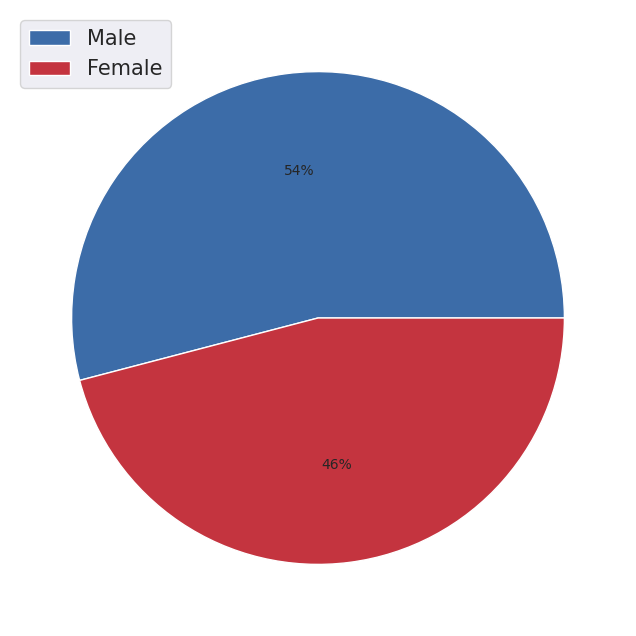

In [17]:
# gender
gender_pallete = [pallete[0], pallete[8]]

aux = df4['gender'].value_counts()
plt.pie( aux,  autopct = '%0.0f%%', colors=gender_pallete)
plt.legend( labels=aux.index, fontsize=15, loc='upper left' );

As shown here below, there's a distribution that seems to be really close in their behavior related to the target variable. The age doesn't change too much from each category. But the median of the ages for the category '1' is a little bit higher than the median value from the category '0' 

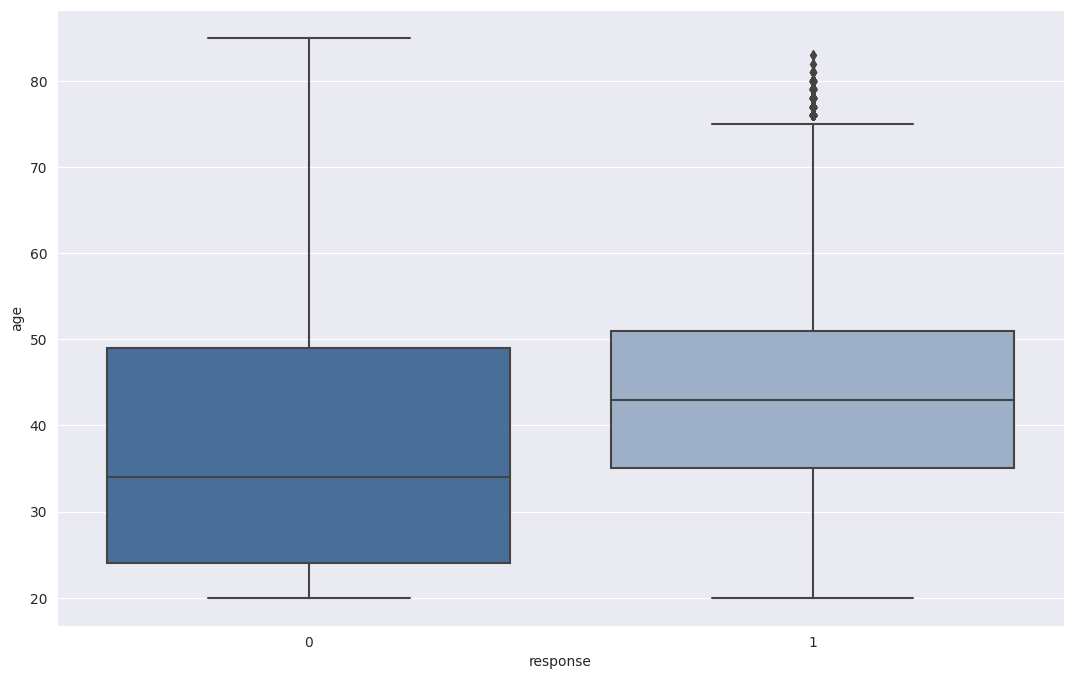

In [18]:
# 'age'
age_pallete = [pallete[0], pallete[2]]
sns.boxplot( data= df4, y='age', x='response', palette=age_pallete );

/tmp/ipykernel_261850/3892560215.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot( data=aux00, palette=age_pallete[0], ax=axes[0])


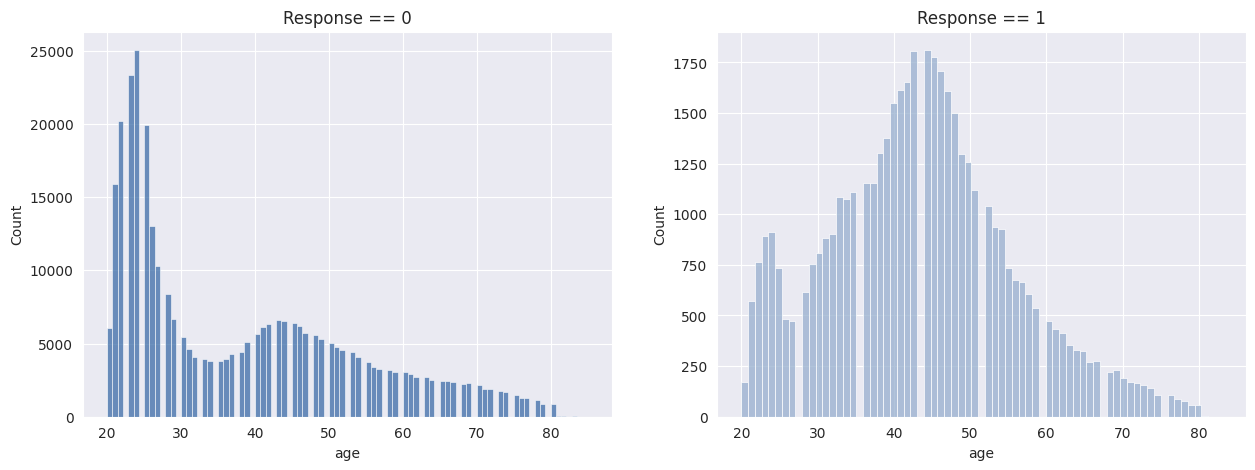

In [19]:
fig, axes = plt.subplots( ncols=2, figsize=(15,5) )

# response == 0
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( data=aux00, palette=age_pallete[0], ax=axes[0])
axes[0].set_title( 'Response == 0' )

# response == 1
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( data=aux00, color=age_pallete[1], ax=axes[1])
axes[1].set_title( 'Response == 1' );

without a filter is hard to catch the behavior of this variable, It's hard to understand how the distribution of the variable actually is. Because there are lots of points shown as an outlier on this boxplot

Applying a filter makes this job easier. Now I'm able to see that this variable doesn't bring me lots of information alone. Because its behavior doesn't change from each category from the target variable

Text(0.5, 1.0, 'Annual Premium Filtered')

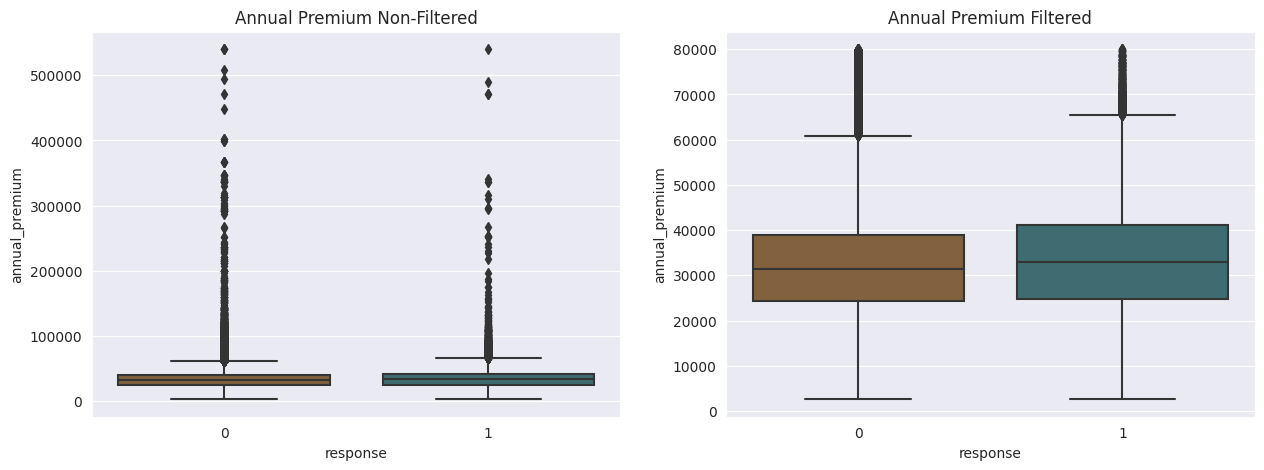

In [20]:
fig, axes = plt.subplots( ncols=2, figsize=(15,5) )

# 'annual_premium'
annual_premium_pallete = [pallete2[0], pallete2[8]]
sns.boxplot( data= df4, y='annual_premium', x='response', palette=annual_premium_pallete, ax=axes[0] )
axes[0].set_title( 'Annual Premium Non-Filtered' )


# 'annual_premium' filtered
annual_premium_pallete = [pallete2[0], pallete2[8]]

aux = df4[df4['annual_premium']<80000]
sns.boxplot( data= aux, y='annual_premium', x='response', palette=annual_premium_pallete, ax=axes[1] )
axes[1].set_title( 'Annual Premium Filtered' )

Applying another filter to see how the distribution of the data in this variable behavior alone through these histograms.

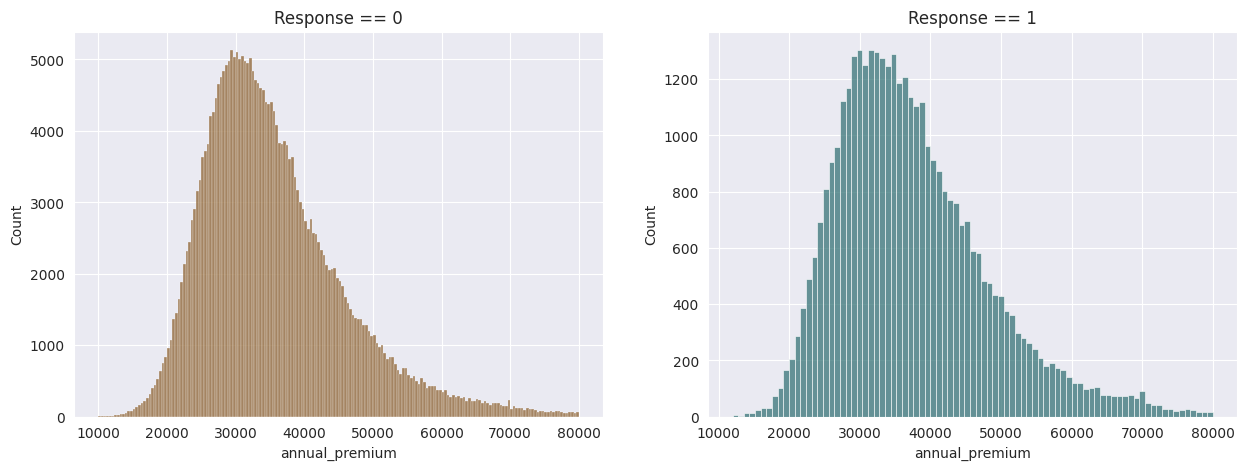

In [21]:
fig, axes = plt.subplots( ncols=2, figsize=(15,5) )

aux = df4[ (df4['annual_premium']<80000) & (df4['annual_premium']>10000)]

# reponse == 0
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( data=aux00, color=annual_premium_pallete[0], ax=axes[0] )
axes[0].set_title( 'Response == 0' )

# reponse == 1
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( data=aux00, color=annual_premium_pallete[1], ax=axes[1] )
axes[1].set_title( 'Response == 1' );

For this variable "driving license" which is a categorical variable such as the target variable, I decided to make a frequency table to show how much time the occurring happen for this variable related to each categorical value from the target variable. The table is shown in terms of the percentage

The result sounds right or at least makes sense. Because it's expected that, people who already have their license might have a vehicle already and if the people have a vehicle makes sense they already have insurance. But it's not a statement yet, it's just the initial feeling. 

In [22]:
# driving_license
pd.crosstab( df4['driving_license'], df4['response'], normalize='columns' )

response,0,1
driving_license,,
0,0.002306,0.000878
1,0.997694,0.999122


In this step, the central idea was to identify for each region how many people answered the target variable as 0 or 1. 

As seen in the scatterplot below it's hard to separate the people who marked the response as 1 from the people who marked it as 0. The number of people that answered 1 or 0 is really close.

It might mean that this variable alone doesn't bring a lot of information.

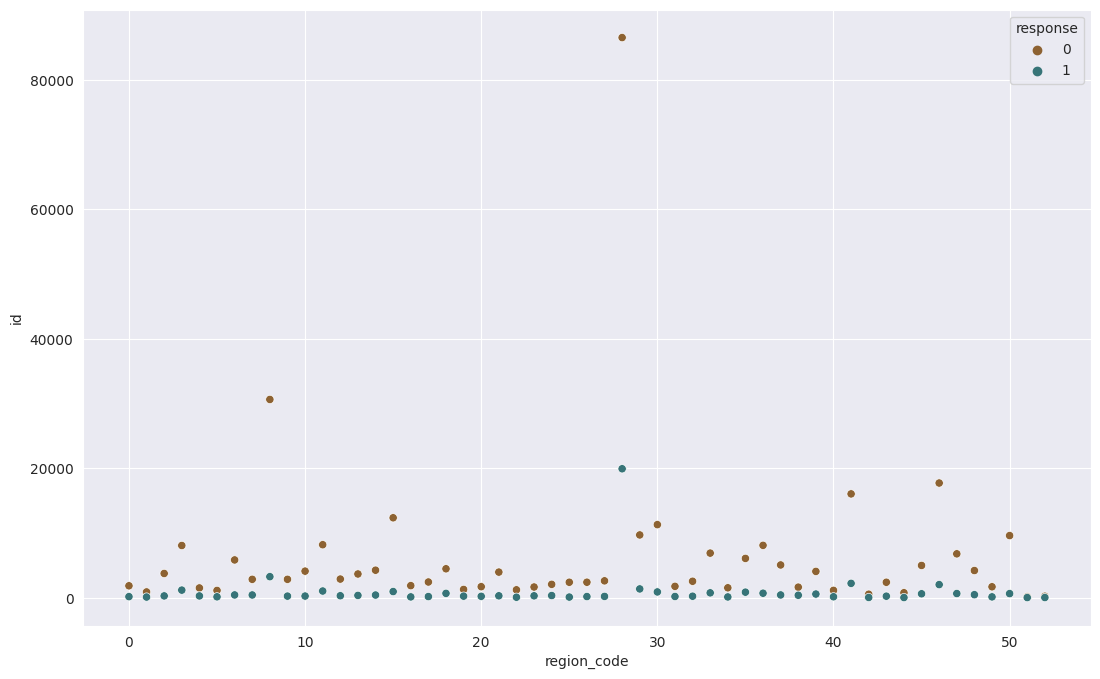

In [23]:
# region_code
region_pallete = [pallete2[0], pallete2[8]]

aux = df4[['id','region_code','response']].groupby( ['region_code','response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux, palette=region_pallete );

for this variable, I decided to make a frequency table as well to show in terms of percentage the number of people who are already insured or not and who answered 0 or 1.

In [24]:
# previously_insured related to the response variable
pd.crosstab( df4['previously_insured'], df4['response'], normalize='columns' )

response,0,1
previously_insured,,
0,0.478258,0.996617
1,0.521742,0.003383


In [25]:
# previously_insured as a whole
pd.crosstab( df4['previously_insured'], df4['response'], normalize=True )

response,0,1
previously_insured,,
0,0.419641,0.122149
1,0.457796,0.000415


A frequency table was done to count the occurrence of people who answer the target variable for each vehicle age listed.

As shown, below_1_year and between_1_2_years are the variables that concentrate the most percentage of people who answered and these people answered 0.

In [26]:
# vehicle_age
df4[['vehicle_age','response']].value_counts( normalize=True ).reset_index().sort_values( 'vehicle_age' )

,vehicle_age,response,0
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


In [27]:
df4['vehicle_age'].value_counts(normalize=True)

between_1_2_years    0.525613
below_1_year         0.432385
over_2_years         0.042001
Name: vehicle_age, dtype: float64

For this variable, if I don't apply any filter makes the job harder. So, below I'm going to filter the data to visualize it better.

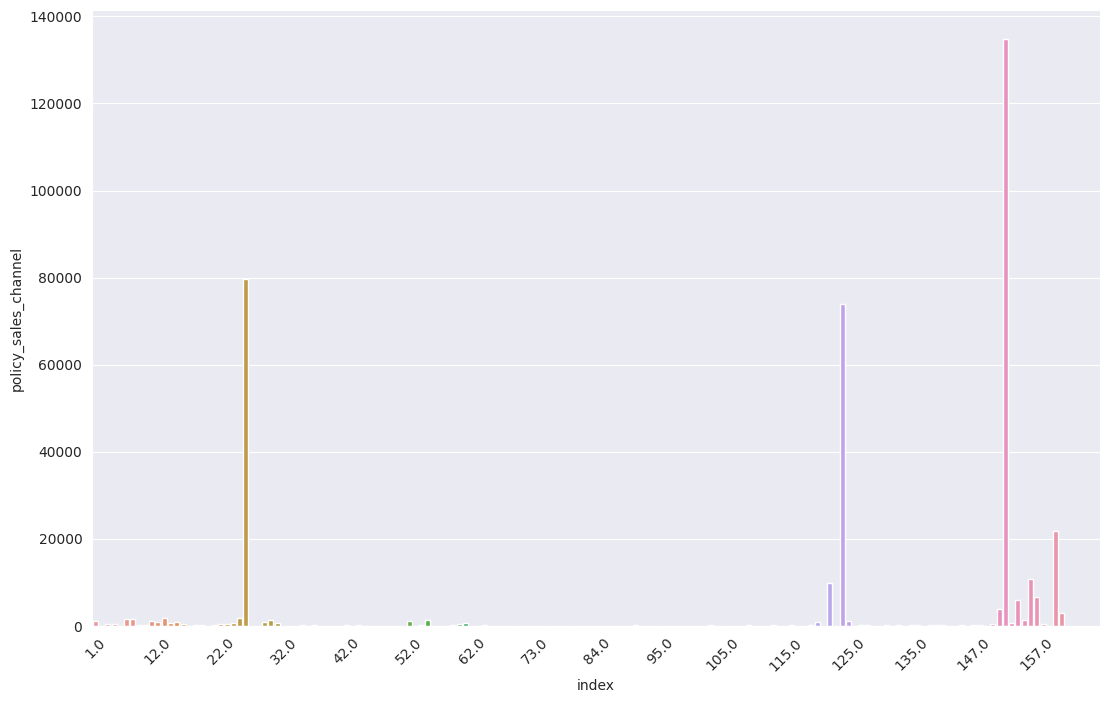

In [28]:
# policy_sales_channel
aux = df4['policy_sales_channel'].astype( 'object' ).value_counts().reset_index().sort_values( 'index' )
sns.barplot( data=aux, x='index', y='policy_sales_channel' )
plt.xticks( range(0,161,10), rotation=45 );

As seen the policy sales channel with more people as seen in the graph above are:
- 152
- 26
- 124
- 160

In [29]:
aux_ = df4['policy_sales_channel'].value_counts( normalize=True ).head(4)*100
aux_

152.0    35.366260
26.0     20.912652
124.0    19.415705
160.0     5.714638
Name: policy_sales_channel, dtype: float64

These four channels together represent more than 80% of the people in the dataset. In other words, more than 80% of the people choose one of these channels

In [30]:
aux_.cumsum()

152.0    35.366260
26.0     56.278912
124.0    75.694618
160.0    81.409256
Name: policy_sales_channel, dtype: float64

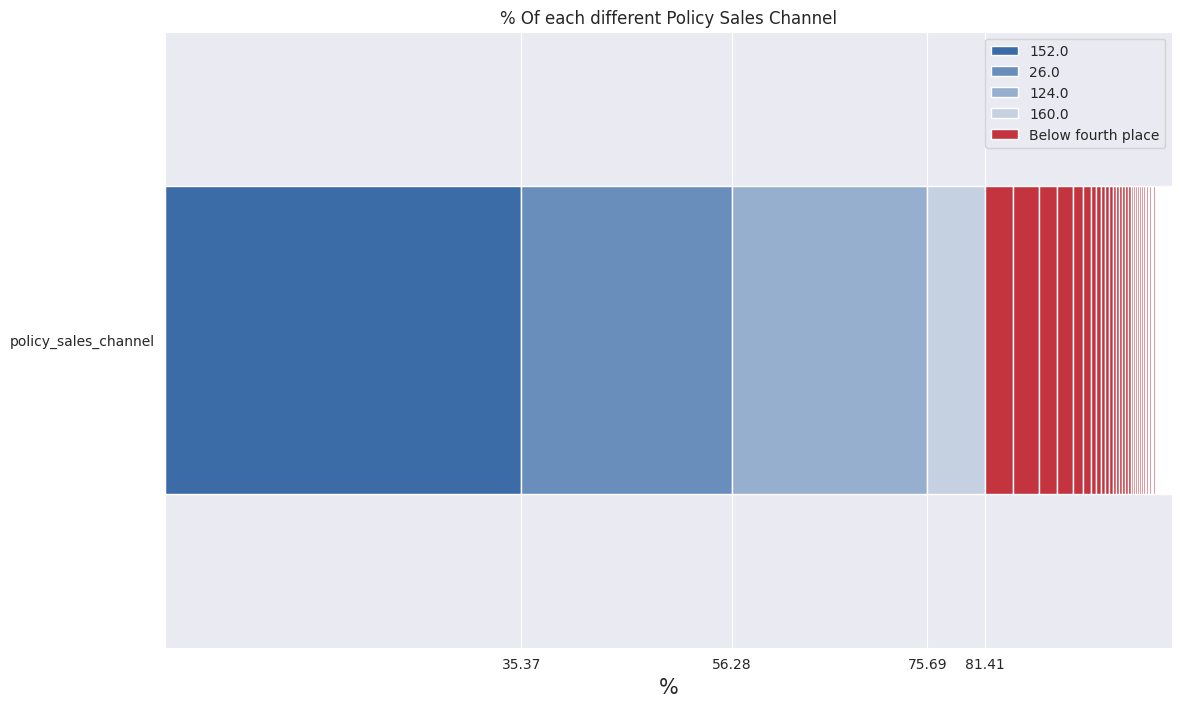

In [31]:
# palette definition
palette_aux = pallete[:4]

for i in range(151):
    palette_aux.append( pallete[8] )

# aux dataframe
aux = df4.copy()
aux['policy_sales_channel'] = aux['policy_sales_channel'].astype( 'object' )

df = pd.DataFrame( aux['policy_sales_channel'].value_counts( normalize=True )*100 ).T 

# legend
legend = aux_.index.to_list()
legend.append( 'Below fourth place' )

df.plot( kind='barh', stacked=True, color=palette_aux )
plt.title( '% Of each different Policy Sales Channel' )
plt.xlabel( '%', fontsize=15 )
plt.xticks( aux_.cumsum() )
plt.legend( legend );

This has a uniform behavior, it might suggest that this variable might not be useful to our prediction model.

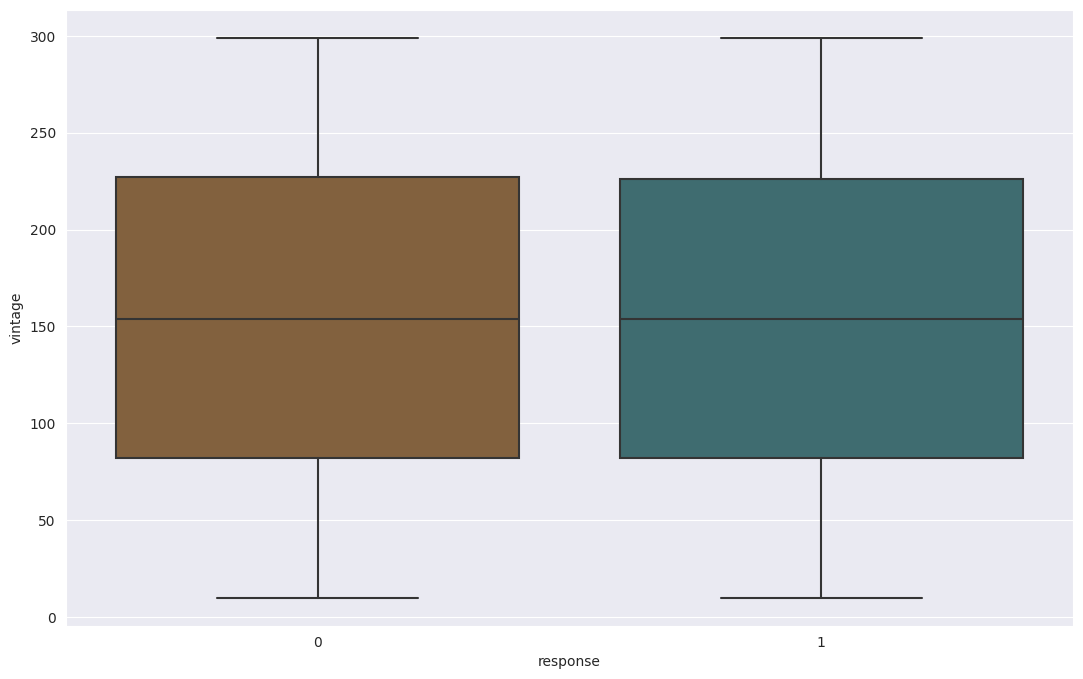

In [32]:
# vintage
vintage_pallete = [pallete2[0], pallete2[8]]

sns.boxplot( data= df4, y='vintage', x='response', palette=vintage_pallete );

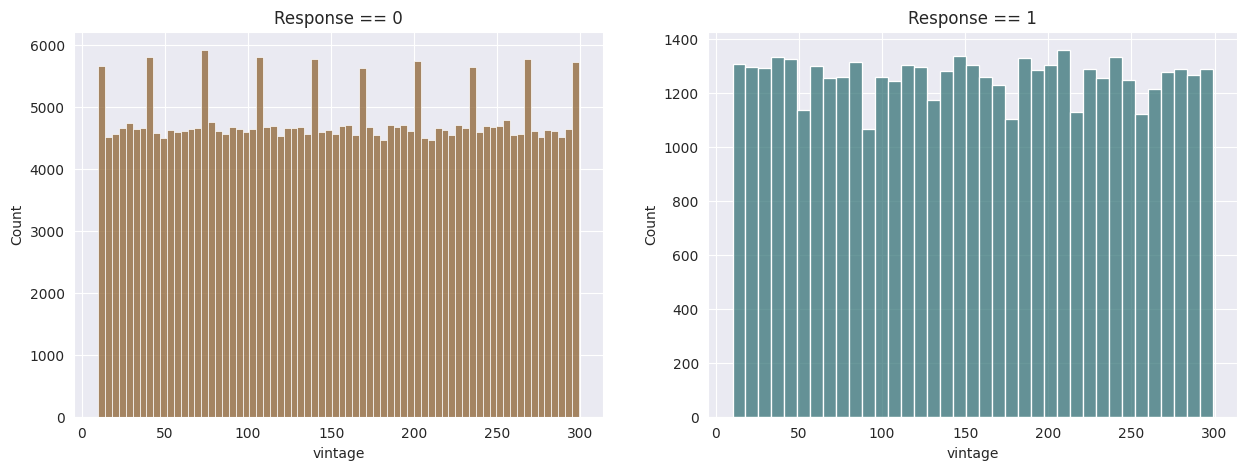

In [33]:
fig, axes = plt.subplots( ncols=2, figsize=(15,5) )

# response == 0
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( data=aux00, color=vintage_pallete[0], ax=axes[0] )
axes[0].set_title( 'Response == 0' )

# response == 1
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( data=aux00, color=vintage_pallete[1], ax=axes[1] )
axes[1].set_title( 'Response == 1' );

these variables are very balanced.

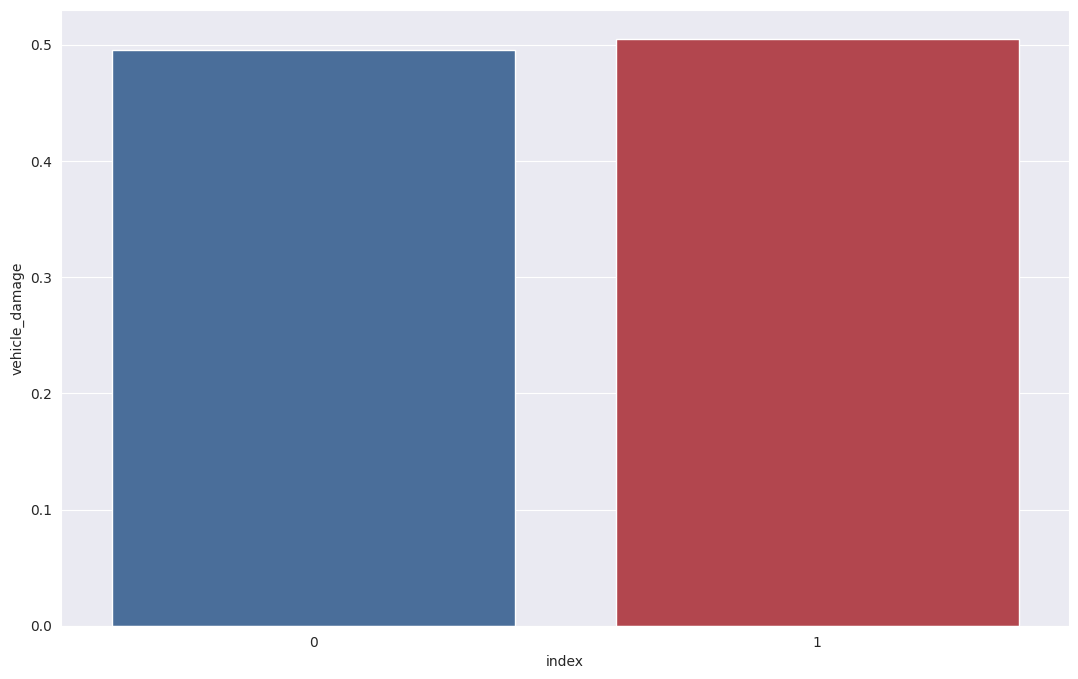

In [34]:
# vehicle_damage
aux = df4['vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete );

Applying a filter for each target category(0 or 1) it's possible to see some behavior... when the variable target chosen is 1 there is a clearly unbalanced in this variable.

For people who have answered the question as 1(YES) the most of them didn't already have vehicle damage, which might mean that people are worried and want to take care of their vehicles. And then they feel like getting insurance to feel less worried. 

What is different from the expected is from people who answered the question as 0(NO). Because the most people who answered NO are people who already had a vehicle damaged. This is interesting, for me people who already have an accident or vehicle damage are more worried about that incident happening again and then they get insurance to prevent that. 

Completely different behaviors between this variable from people who answer "YES" and "NO" for acquiring the new insurance.

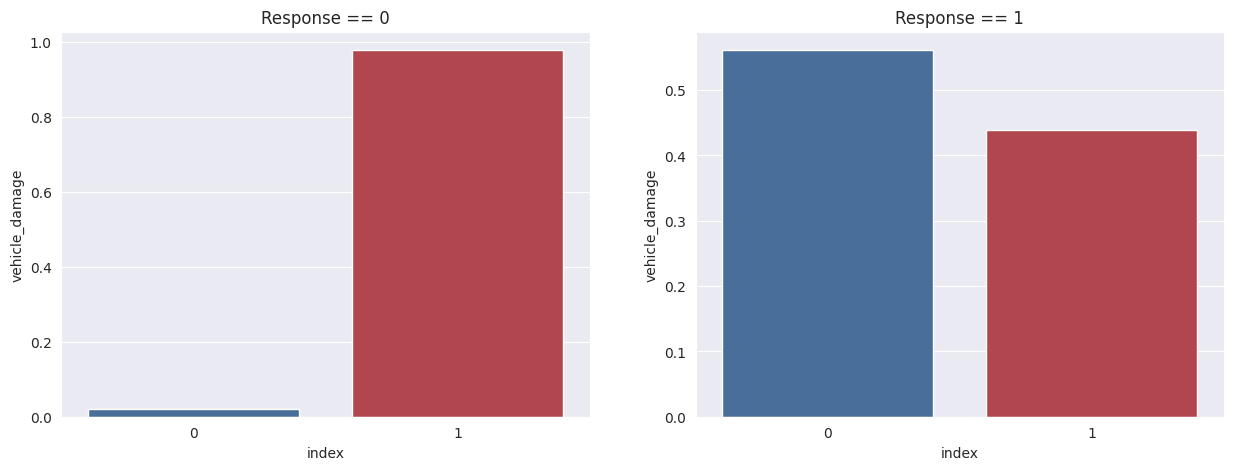

In [35]:
fig, axes = plt.subplots( ncols=2, figsize=(15,5) )

# response == 1
aux = df4.loc[ df4['response']==1, 'vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete, ax=axes[0]);
axes[0].set_title( 'Response == 0' )

# response == 0
aux = df4.loc[ df4['response']==0, 'vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete, ax=axes[1])
axes[1].set_title( 'Response == 1' );

In the target variable is visible that there are clearly unbalanced data here.

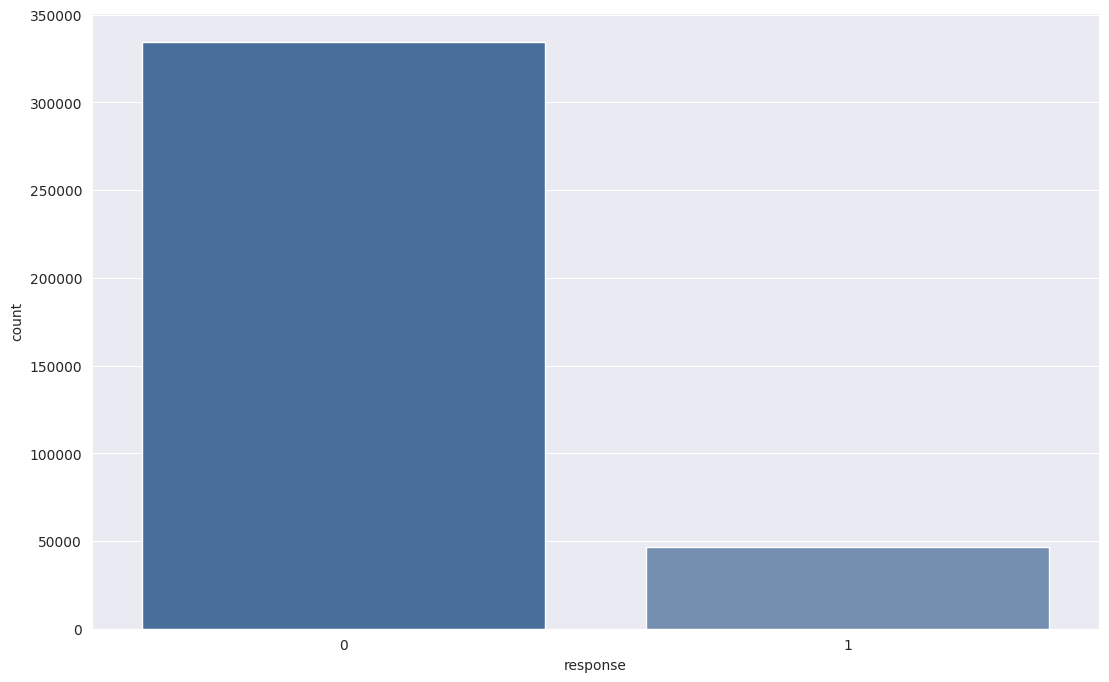

In [36]:
# response
sns.countplot( x='response', data=df4 );

## 4.2. Business Hypotesis

1. Customers without a driving license should not want a vehicle insurance
2. Women are most likely to want a vehicle insurance
3. Customers aged 40 and over should be more interested in  the insurance
4. Clients who damaged their cars are more likely to want the insurance
5. Clients with +100 vintage should want the insurance
6. Men has more vehicles damaged than women.

### H1. Customers without a driving license should not want a vehicle insurance - TRUE

In [37]:
aux = df4[['driving_license','response']].groupby( 'driving_license' ).sum().reset_index()
aux['response%'] = aux['response'] / aux['response'].sum()
aux

,driving_license,response,response%
0,0,41,0.000878
1,1,46669,0.999122


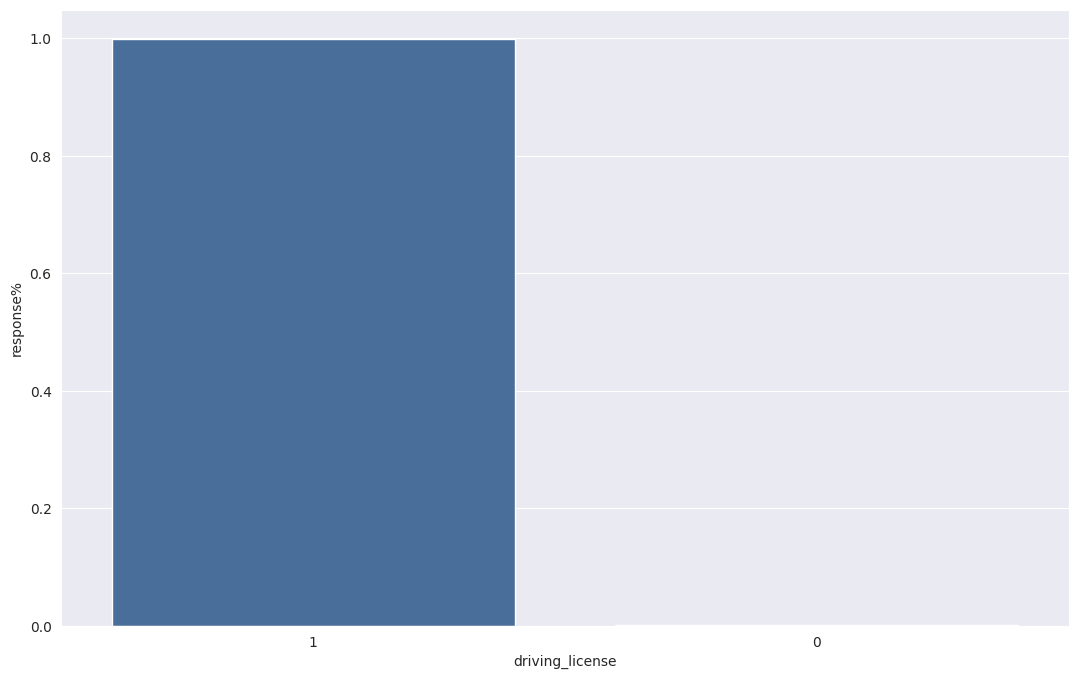

In [38]:
sns.barplot( data=aux, x='driving_license', y='response%', order=[1,0] );

### H2. Women are most likely to want a vehicle insurance - FALSE

In [39]:
aux = df4[['gender','response']].groupby( 'gender' ).sum().reset_index()
aux['response%'] = aux['response'] / aux['response'].sum()
aux

,gender,response,response%
0,Female,18185,0.389317
1,Male,28525,0.610683


### H3. Customers aged 40 and over should be more interested in  the insurance - TRUE

In [40]:
aux = df4.copy()
aux['more_than_40'] = aux['age'].apply( lambda x: 'Yes' if x>40 else 'No' )

aux_02 = aux[['more_than_40','response']].groupby( 'more_than_40' ).sum().reset_index()
aux_02

,more_than_40,response
0,No,18780
1,Yes,27930


### H4. Clients who damaged their cars are more likely to want the insurance - TRUE

In [41]:
df4[['vehicle_damage','response']].groupby( 'vehicle_damage' ).sum().reset_index()

,vehicle_damage,response
0,0,982
1,1,45728


### H5. Clients with +100 vintage should want the insurance more than clients who hasn't - TRUE

In [42]:
aux = df4.copy()
aux['more_than_100_vintage'] = aux['vintage'].apply( lambda x: 'Yes' if x>=100 else 'No' )

aux[['more_than_100_vintage','response']].groupby( 'more_than_100_vintage' ).sum().reset_index()

,more_than_100_vintage,response
0,No,14508
1,Yes,32202


### H6. Men has more vehicles damaged than women - TRUE

In [43]:
pd.crosstab( df4['gender'], df4['vehicle_damage'] )

vehicle_damage,0,1
gender,,
Female,95355,79665
Male,93341,112748


In [44]:
df4[['gender','vehicle_damage']].groupby( 'gender' ).sum().reset_index()

,gender,vehicle_damage
0,Female,79665
1,Male,112748


### Final Hypotesis table

In [45]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1 - Customers without a driving license should not want a vehicle insurance', 'True', 'Low'],  
      ['H2 - Women are most likely to want a vehicle insurance', 'False', 'High'],  
      ['H3 - Customers aged 40 and over should be more interested in  the insurance', 'True', 'Medium'],
      ['H4 - Clients who damaged their cars are more likely to want the insurance', 'True', 'High'],
      ['H5 - Clients with +100 vintage should want the insurance', 'True', 'Low'],
      ['H6 - Men has more vehicles damaged than women', 'True', 'Low']]

print(tabulate(tab, headers='firstrow', tablefmt = 'fancy_grid'))

╒══════════════════════════════════════════════════════════════════════════════╤══════════════╤═════════════╕
│ Hypothesis                                                                   │ Conclusion   │ Relevance   │
╞══════════════════════════════════════════════════════════════════════════════╪══════════════╪═════════════╡
│ H1 - Customers without a driving license should not want a vehicle insurance │ True         │ Low         │
├──────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H2 - Women are most likely to want a vehicle insurance                       │ False        │ High        │
├──────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H3 - Customers aged 40 and over should be more interested in  the insurance  │ True         │ Medium      │
├──────────────────────────────────────────────────────────────────────────────┼──────────────┼─────────────┤
│ H4 - Cli

## 4.3. Multivariate analysis

### 4.3.1 Numerical Attributes

<AxesSubplot: >

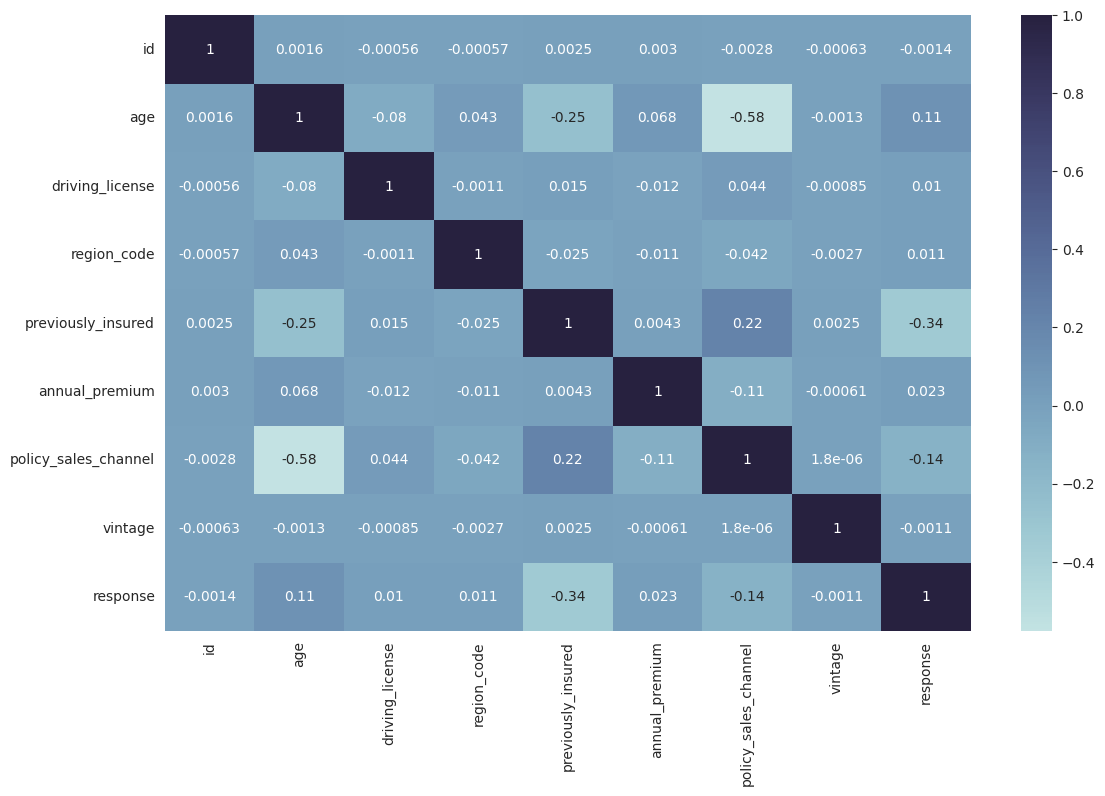

In [46]:
corr = num_attributes.corr( method='pearson' )
sns.heatmap( corr, annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True) )

### 4.3.2 Categorical Attributes

In [47]:
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


<AxesSubplot: >

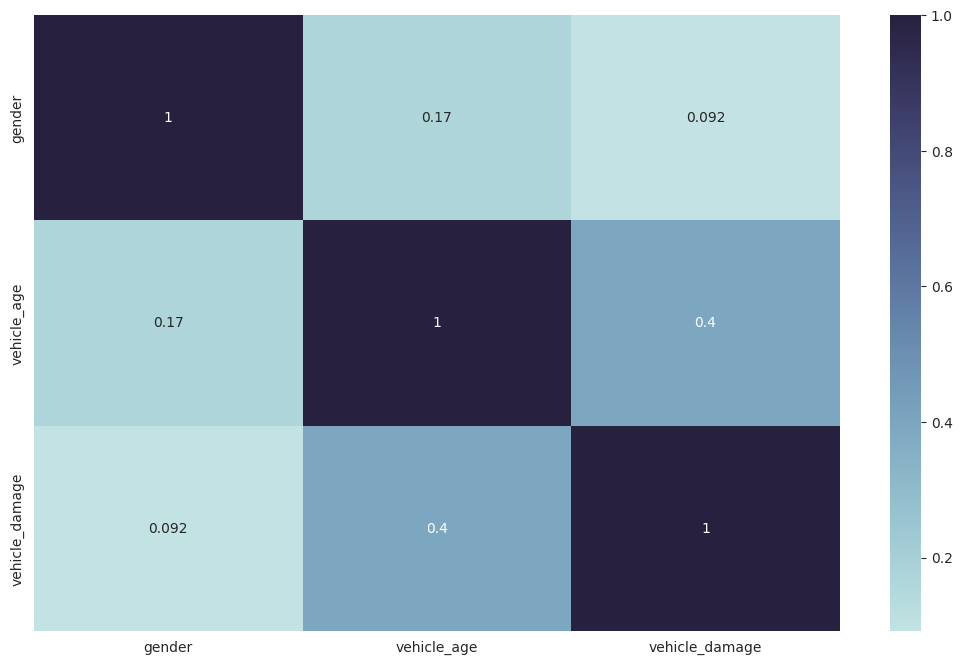

In [48]:
list_01 = []
list_02 = []
list_03 = []

for i in range(3):
    for j in range(3):
        a = cramer_v( cat_attributes.iloc[:,i], cat_attributes.iloc[:,j] )
        
        if i==0:
            list_01.append(a)
            
        elif i==1:
            list_02.append(a)
            
        else:
            list_03.append(a)

aux = pd.DataFrame( [list_01,list_02,list_03], index=cat_attributes.columns, columns=cat_attributes.columns )

sns.heatmap( data=aux, annot=True , cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))

# 5.0. Data Preparation

In [49]:
X = df4.drop( 'response', axis=1 )
y = df4['response']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )

df5 = pd.concat( [X_train,y_train], axis=1 )

## Standardization

In [50]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( '../app/parameters/annual_premium_scaler.pkl','wb') )

## Rescaling

In [51]:
mms_age     = MinMaxScaler()
mms_vintage = MinMaxScaler()
# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( '../app/parameters/age_scaler.pkl', 'wb') )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( '../app/parameters/vintage.pkl', 'wb') )

## Encoder

In [52]:
# gender
target_encoding_gender = df5.groupby( 'gender' )['response'].mean()
df5['gender'] = df5['gender'].map( target_encoding_gender )
pickle.dump( target_encoding_gender, open( '../app/parameters/gender_encoder.pkl', 'wb') )

# region_code -  Target encoding
target_encoding_region_code = df5.groupby( 'region_code' )['response'].mean()
df5['region_code'] = df5['region_code'].map( target_encoding_region_code )
pickle.dump( target_encoding_region_code, open( '../app/parameters/region_encoder.pkl', 'wb') )
                               
# vehicle_age - One Hot Encoding 
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - frequency enconding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '../app/parameters/policy_sales_channel_encoder.pkl', 'wb') )

# 6.0. Feature Selection

## Features Importancia

In [53]:
# Model definition
forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1 )

# data preparation
X_train_n = df5.drop( ['id','response'], axis=1 )
y_train_n = df5['response'].values
forest.fit( X_train_n, y_train_n )

ExtraTreesClassifier(n_jobs=-1, random_state=0)

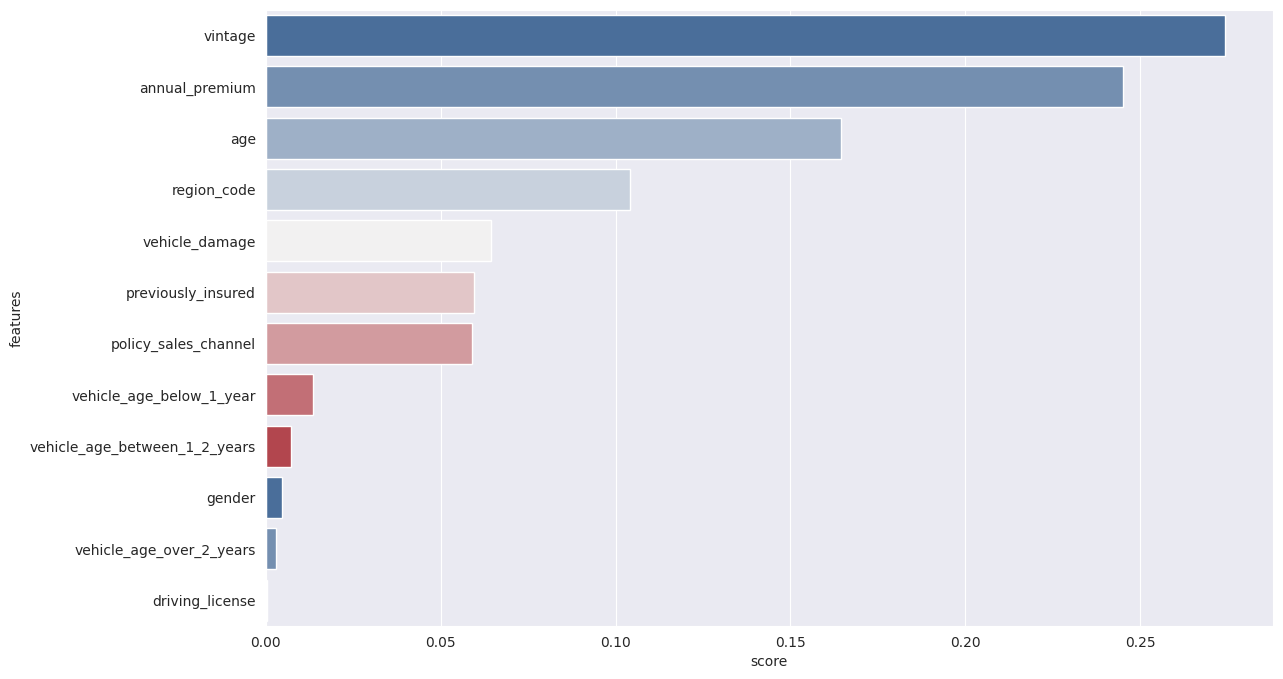

In [54]:
importances = forest.feature_importances_
indices = np.argsort( importances )[::-1]

df = pd.DataFrame()

for i,j in zip( X_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis=0 )
    
# plot
features = pd.DataFrame( {'features': X_train_n.columns, 'score': importances} ).sort_values( 'score', ascending=False )
sns.barplot( data=features, x='score', y='features', palette=pallete );

In [55]:
df.sort_values( 'importance', ascending=False )

,feature,importance
0,vintage,0.274167
0,annual_premium,0.244897
0,age,0.164489
0,region_code,0.104178
0,vehicle_damage,0.064508
0,previously_insured,0.059604
0,policy_sales_channel,0.059047
0,vehicle_age_below_1_year,0.013600
0,vehicle_age_between_1_2_years,0.007390
0,gender,0.004605


In [56]:
X = df5.drop( 'response', axis=1 )
y = df5['response'] 

X_train, X_validation, y_train, y_validation = train_test_split( X, y, test_size=0.2 )

In [57]:
cols_selected = ['vintage', 'annual_premium','age', 'region_code',  'vehicle_damage','previously_insured',
                 'policy_sales_channel']  

# data with selected columns
X_train_selected = X_train[cols_selected].copy()
y_train_selected = y_train.copy()

X_val = X_validation[cols_selected].copy()
y_val = y_validation.copy()

# 7.0. Machine Learning

## 7.1. KNN

In [1]:
knn

NameError: name 'knn' is not defined

In [58]:
# model definition
knn = KNeighborsClassifier( n_neighbors=5 )

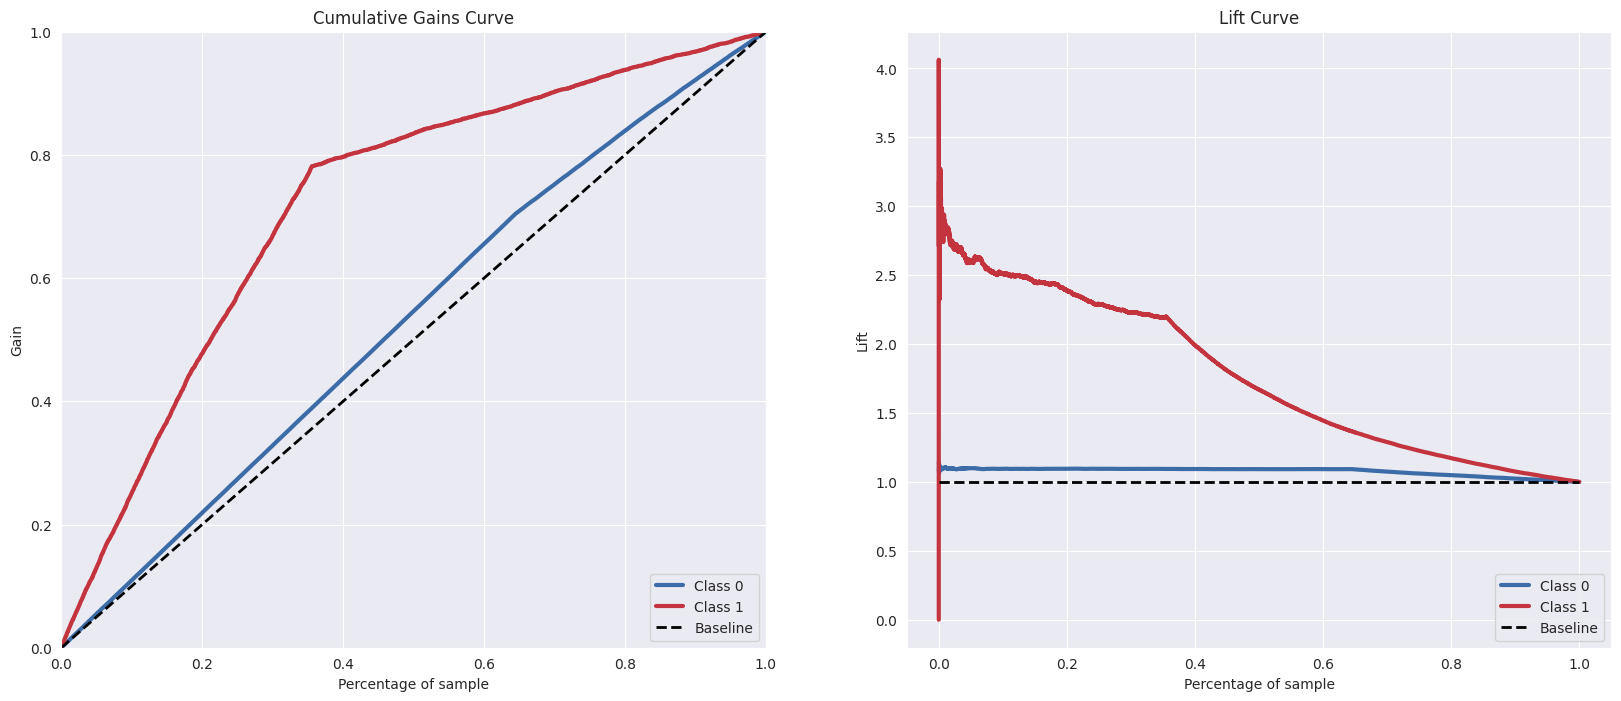

In [59]:
# model definition
knn = KNeighborsClassifier( n_neighbors=5 )

# model trainijng
knn.fit( X_train_selected, y_train_selected )

# model prediction - poder de genaralização
yhat_knn = knn.predict_proba( X_val )

paletteaux = [pallete[0], pallete[8]]
sns.set_palette( paletteaux )

fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# Acumalitve gain
plot_cumulative_gain( y_val, yhat_knn, ax=axes[0])
plot_lift_curve( y_val, yhat_knn, ax=axes[1]);

## 7.2. Logistic Regression

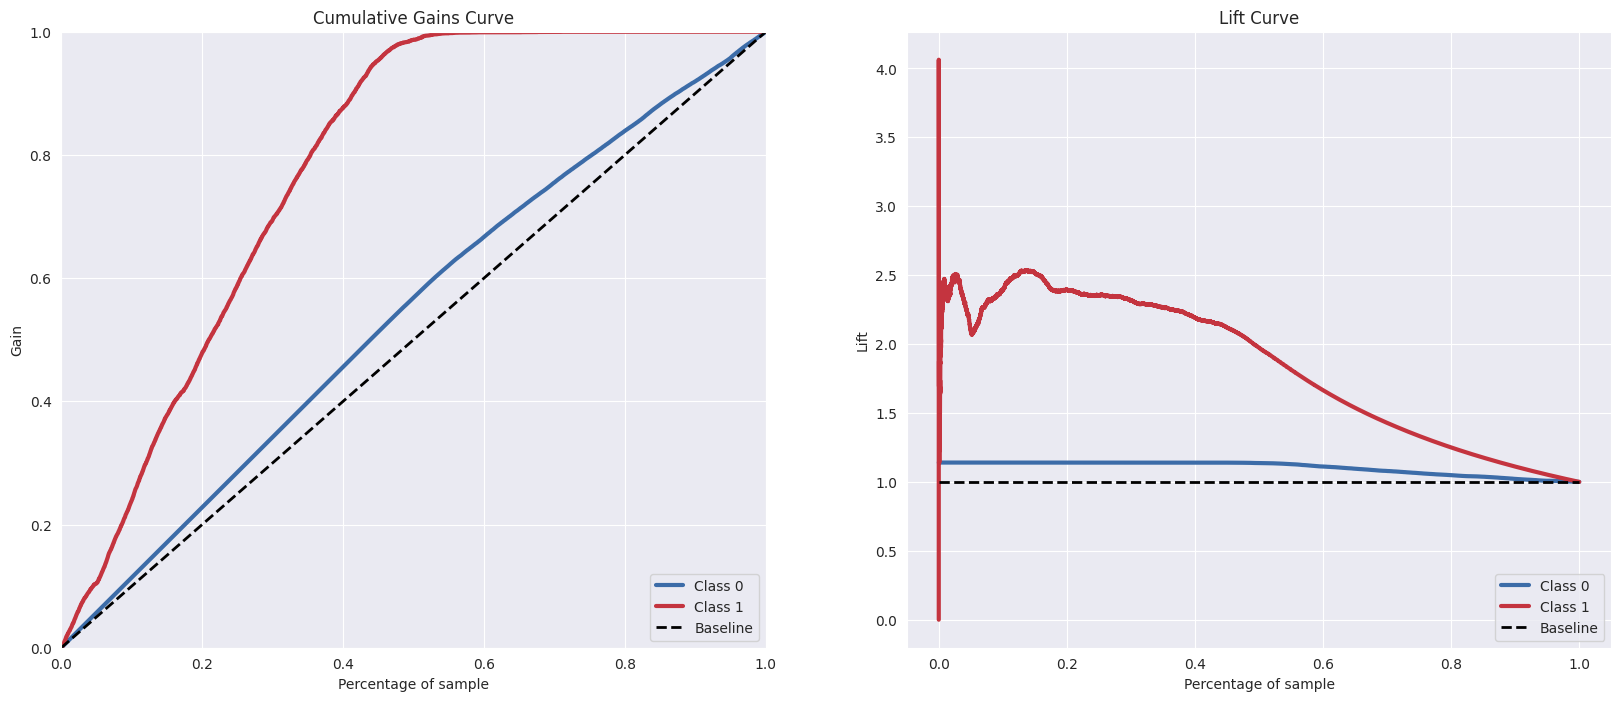

In [60]:
# model definition
lg = LogisticRegression( random_state=42 )

# model training
lg.fit( X_train_selected, y_train_selected )

# predict
yhat_lg = lg.predict_proba( X_val )

fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# Acumalitve gain
plot_cumulative_gain( y_val, yhat_lg, ax=axes[0])
plot_lift_curve( y_val, yhat_lg, ax=axes[1]);

## 7.3. Random Forest

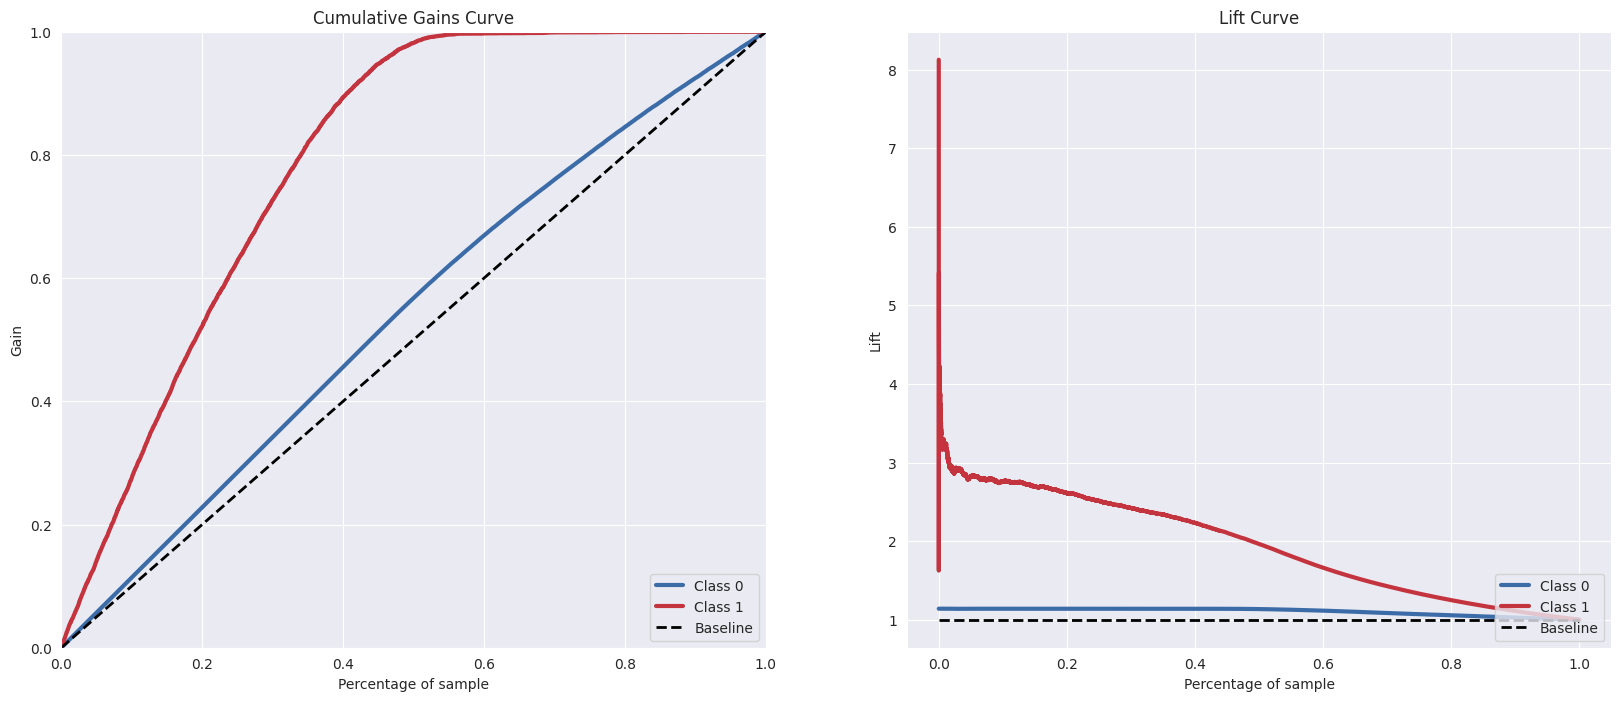

In [61]:
# model definition
rf = RandomForestClassifier( n_estimators=250, random_state=42, n_jobs=-1 )

# model training
rf.fit( X_train_selected, y_train_selected )

# predict
yhat_rf = rf.predict_proba( X_val )

fig, axes = plt.subplots(1, 2, figsize = (20, 8))
# Acumalitve gain
plot_cumulative_gain( y_val, yhat_rf, ax=axes[0])
plot_lift_curve( y_val, yhat_rf, ax=axes[1]);

## 7.5. Comparing the diferents performaces

In [ ]:
precision_at_k_knn = cross_validation( X_train, y_train, knn, 10, cols_selected, 20000 )
precision_at_k_lg  = cross_validation( X_train, y_train, lg, 10, cols_selected, 20000 )
precision_at_k_rf  = cross_validation( X_train, y_train, rf, 10, cols_selected, 20000 )

In [ ]:
pd.DataFrame( [precision_at_k_knn,precision_at_k_lg,precision_at_k_rf], index=['KNN','Logistic Regression','Random Forest'] )

# 8.0. Model Performace

Chosen model: Logistic Regression

In [ ]:
# model definition
lg = LogisticRegression( random_state=42 )

# model training
lg.fit( X_train_selected, y_train_selected )
pickle.dump( lg, open( 'models/model.pkl', 'wb') )

# predict
yhat_lg = lg.predict_proba( X_val )

As seen the model perform well, with the information of the acumulative gain we're able to see that if I almost 20% from my dataset I'm able to reach almost 50% of the people who are interested in acquirer the new insurance.

Together with the information of the lift curve I'm able to see that the model perform 2 times better than the baseline model (which is a model who choose a costumer randomly) until almost 50% of my dataset

In [ ]:
fig, axes = plt.subplots( ncols=2, figsize=(20,8) )

results = pd.DataFrame()
results['prediction'] = yhat_lg[:,1].tolist()
results['real'] = y_val.tolist()

# para classe 0 altera yhat tbm
# results['real'] = results['real'].apply( lambda x: 0 if x==1 else 1 )

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# # Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results, label='model', ax=axes[0], color=pallete[8])
sns.lineplot( x='base_cum_perc', y='baseline', data=results, label='baseline', ax=axes[0] )
axes[0].set_title( 'Cumulative Gain' )
axes[0].set_ylabel( 'Cumulative Gain of interested customers %', size=15 )
axes[0].set_xlabel( 'DataSet %', size=15 );


################
## lift curve ##
################
results = pd.DataFrame()
results['prediction'] = yhat_lg[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results, ax=axes[1] )
axes[1].set_title( 'Lift Curve')
axes[1].set_ylabel( 'Model Performance', size=15 )
axes[1].set_xlabel( 'DataSet %', size=15 );

Here It's shown the precision and recall at K as a metric to analyse the performace.

- **precision at K** means the amount of data "at K" elements that are classified as 1(the wanted class to be analysed). In other words, inside of the data that I have until the K element how much I got right.


- **recall at K** means how much data until K elements represent of all wanted data from my whole dataset.

In [ ]:
df8 = X_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_lg[:,1].tolist()

df8 = df8.sort_values( 'score', ascending=False )

# print precision at k
precision_at_50 = precision_at_k( df8, k=20000 )[0]
print(f' Precision at K: {precision_at_50}' )

# print recall at k
recall_at_50 = recall_at_k( df8, k=50 )[0]
print(f' Recall at K: {recall_at_50}' )

Here It's shown how the recall and precision at K run through the whole dataset. It's expected this behavior, the precision is going to decrease as going through all the data because of that:
how much more data I cover, more unwanted points that are not classified as 1 I'll get.

recall at K otherwise is increasing as going through all data because how much more data I cover more data classified as 1 I'll get.

In [ ]:
recall_at_k( df8, k=20000 )[1]['recall_at_k'].plot()
precision_at_k( df8, k=20000 )[1]['precision_at_k'].plot()

plt.legend()

# 9.0. Test API

In [ ]:
df_test = X_test
# df_test['response'] = y_test

df_test = df_test.sample(10, random_state=10)

In [ ]:
data = df_test.sample(2).to_json(orient="records")

In [ ]:
data

In [ ]:
url = f"http://0.0.0.0:8001/predict?test_json={data}"

r = requests.post(url)
print('Status Code {}'.format(r.status_code))

In [ ]:
pd.read_json(r.json(), orient='records', dtype=False)

## 9.1. Test API in Production

In [ ]:
df_test = pd.read_csv( 'data/test.csv' )
df_test = df_test.sample(10, random_state=10)

data = json.dumps( df_test.to_dict( orient='records' ) )

url = 'https://healthinsurance-prediction.herokuapp.com/predict'

header = {'Content-type': 'application/json' }
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
df_response = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

df_response[['id','score']]

# 10.0. Business Questions

## 10.1. Main Insights

### 1.0.

For the people who answered "NO" for acquiring the new car insurance, the distribution of the people are almost fifty-fifty. on the other hand, for people who answered "YES" for acquiring the new insurance practically 100% are people who weren't previously insured. 

I thought in this hypothesis:
   - for the people who answered "YES" most of them are not previously insured, it makes sense. People who already have no insurance might search for one. But for people who answered "NO" there are a lot of people who are not insured yet. before I see the data I was expecting to see something different. Why half of the people who answered "NO" are people who don't have insurance?

is the insurance not good enough? too expensive?  

In [ ]:
# previously_insured related to the response variable
pd.crosstab( df4['previously_insured'], df4['response'], normalize='columns' )

### 2.0. 

These four channels together represent around of 80% of the people in the dataset. In other words, around of 80% of the people choose one of these channels

In [ ]:
# palette definition
palette_aux = pallete[:4]

for i in range(151):
    palette_aux.append( pallete[8] )

# aux dataframe
aux = df4.copy()
aux['policy_sales_channel'] = aux['policy_sales_channel'].astype( 'object' )

df = pd.DataFrame( aux['policy_sales_channel'].value_counts( normalize=True )*100 ).T 

# legend
legend = aux_.index.to_list()
legend.append( 'Below fourth place' )

df.plot( kind='barh', stacked=True, color=palette_aux )
plt.title( '% Of each different Policy Sales Channel' )
plt.xlabel( '%', fontsize=15 )
plt.xticks( aux_.cumsum() )
plt.legend( legend );

### 3.0.

The oldest client in this dataset has just 300 days with an insurance from this company. It's just one year of experience, the question is: was there people who was insured before and now is no more? and why?  

In [ ]:
df4['vintage'].max()

### 4.0. 

For people who have answered the question as 1(YES) the most of them didn't already have vehicle damage, which might mean that people are worried and want to take care of their vehicles. And then they feel like getting insurance to feel less worried. 

What is different from the expected is from people who answered the question as 0(NO). Because the most people who answered NO are people who already had a vehicle damaged. This is interesting, for me people who already have an accident or vehicle damage are more worried about that incident happening again and then they get insurance to prevent that. 

Completely different behaviors between this variable from people who answer "YES" and "NO" for acquiring the new insurance.

In [ ]:
fig, axes = plt.subplots( ncols=2, figsize=(15,5) )

# response == 1
aux = df4.loc[ df4['response']==1, 'vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete, ax=axes[0]);
axes[0].set_title( 'Response == 0' )

# response == 0
aux = df4.loc[ df4['response']==0, 'vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete, ax=axes[1])
axes[1].set_title( 'Response == 1' );

## What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?

As the cumulative gain curve shows below, 20000 calls which represents almost 33% of the dataset the model predict that nearby 74% of people who are interested will be reached with 20000 calls 

In [ ]:
20000 / y_val.shape[0]

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_lg[:,1].tolist()
results['real'] = y_val.tolist()

# para classe 0 altera yhat tbm
# results['real'] = results['real'].apply( lambda x: 0 if x==1 else 1 )

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# # Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results, label='model', color=pallete[8] )
sns.lineplot( x='base_cum_perc', y='baseline', data=results, label='baseline', color=pallete[0])
plt.axvline( 20000 / y_val.shape[0]*100, color='y');

## And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

The same analysis might be done. 40000 calls which represent almost 66% of the dataset, the model predicts that 100% of people who are interested will be reached with 40000 calls. But not there's no need to go through 66% of the dataset, because with a little bit more than 50% the algorithm already predict to reach 100%. So, it's not necessary to go until 66% of the dataset in order to reduce cost.

In [ ]:
40000 / y_val.shape[0]

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_lg[:,1].tolist()
results['real'] = y_val.tolist()

# para classe 0 altera yhat tbm
# results['real'] = results['real'].apply( lambda x: 0 if x==1 else 1 )

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# # Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results, label='model', color=pallete[8] )
sns.lineplot( x='base_cum_perc', y='baseline', data=results, label='baseline', color=pallete[0])
plt.axvline( 40000 / y_val.shape[0]*100, color='#FFD700', label='66%')
plt.axvline( 50, color='#008080', label='50%')

plt.title( 'Cumulative Gain', fontsize=20 )
plt.ylabel( 'Cumulative Gain of interested customers %', size=14 )
plt.xlabel( 'DataSet %', size=14 )
plt.xticks( range(0,101,10), fontsize=12 )
plt.yticks( range(0,101,10), fontsize=12 );

plt.legend()

plt.savefig( 'teste.png', format='png' );

## How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

To reach 80% of the interested people is need to use around 36% of the dataset which represents nearby 21952 people

In [ ]:
results.loc[ results['base_cum_perc'] > 36 , ['base_cum_perc','real_cum_perc'] ].head(6)

In [ ]:
y_val.shape[0] * 0.36

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_lg[:,1].tolist()
results['real'] = y_val.tolist()

# para classe 0 altera yhat tbm
# results['real'] = results['real'].apply( lambda x: 0 if x==1 else 1 )

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# # Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results, label='model', color=pallete[8] )
sns.lineplot( x='base_cum_perc', y='baseline', data=results, label='baseline', color=pallete[0])
plt.axvline( 36, color='y')

plt.title( 'Cumulative Gain', fontsize=20 )
plt.ylabel( 'Cumulative Gain of interested customers %', size=15 )
plt.xlabel( 'DataSet %', size=15 )
plt.xticks( range(0,101,10), fontsize=12 )
plt.yticks( range(0,101,10), fontsize=12 );

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_lg[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )
plt.title( 'Lift Curve', fontsize=20 )
plt.ylabel( 'Model Performance', size=15 )
plt.xlabel( 'DataSet %', size=15 )
plt.ylim( (0,3) )
plt.xlim( (0, 100) )
plt.savefig( 'test_01.png', format='png' );